### Kernel Density Estimation
Kernel Density Estimation or KDE for short is a technique to estimate the probability density function (PDF) of a random variable on observations. 

The basic idea behind kernel density estimation is to place a kernel function, typically a symmetric and non-negative function, at each data point and then sum up these kernel functions to obtain the estimated density. The kernel function acts as a weighting function that spreads out the influence of each data point to its neighboring points.

### Estimators:
__Input__: $N, X_{(n,)}, K$
  - N is the number of observations
  - x is a random variable
  - X is a vector of N observations
  - h is the bandwidth
  - K is the kernel function

The kernel density estimators of F will be:
$\hat{p}(x) = \frac{1}{nh}\sum_i^N K(\frac{X_i - x}{h})$

### Kernels:
- Rect: $1/2 * I(|u| <= 1)$
- Tri: $1 - |u| * I(|u| <= 1)$
- Par: $3/4 * (1 - u^2) * I(|u| <= 1)$
- Bit: $15/16 * (1 - u^2)^2 * I(|u| <= 1)$
- Gauss: $0.5 * I(|u| <= 1)$
- Silv: $0.5 * I(|u| <= 1)$

### MISE:
MISE is abbreviation of Mean Integrated Squared Error, this metric measure how well the KDE fits true PDF:

$MISE = \sum (p - \hat{p})^2$


### Cross validation unbiased risk
The CV Density Estimators is denoted: $\hat{p}_{n, -i}(x) = \frac{1}{(n - 1)h} \sum_{j, j \ne i}^N K(\frac{X_j - x}{h})$.

The Unbiased Risk: $\int \hat{p}(x)^2 - \frac{2}{N} \sum_1^N \hat{p}_{n, -i}(x)$.

To find the optimal h, we try to find the minimum value of The unbiased risk!

### Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

(array([6.44542202e-01, 2.31743200e-01, 9.48975040e-02, 3.58821548e-02,
        1.28517746e-02, 5.03789566e-03, 2.05628394e-03, 8.22513577e-04,
        2.05628394e-04, 1.02814197e-04]),
 array([3.14286356e-05, 9.72659750e-01, 1.94528807e+00, 2.91791639e+00,
        3.89054471e+00, 4.86317303e+00, 5.83580136e+00, 6.80842968e+00,
        7.78105800e+00, 8.75368632e+00, 9.72631464e+00]),
 <BarContainer object of 10 artists>)

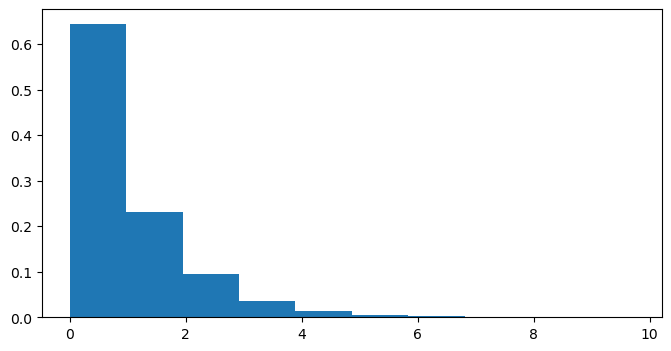

In [2]:
X = np.random.exponential(size=10000)
plt.figure(figsize=(8,4))
plt.hist(X, density=True)

In [3]:
def kernel(u, type: str):
    if type == "rect":
        return 1/2 * (np.abs(u) <= 1)
    elif type == "tri":
        return (1 - np.abs(u)) * (np.abs(u) <= 1)
    elif type == "par":
        return 3/4 * (1 - u**2) * (np.abs(u) <= 1)
    elif type == "bit":
        return 15/16 * (1 - u**2)**2 * (np.abs(u) <= 1)
    elif type == "gauss":
        return 1 / np.sqrt(2 * np.pi) * np.exp(-u**2 / 2)
    elif type == "silv":
        return 1/2 * np.exp(-np.abs(u) / np.sqrt(2)) * np.sin(np.abs(u) / np.sqrt(2) + np.pi/4)
    return None

In [4]:
def kde(X: np.array, x: float, h: float, k: str):
    f = 1 / (len(X) * h)
    s = np.sum(kernel((X - x) / h, k))
    return f * s

In [5]:
def h_rot(X: np.array):
    n = len(X)
    h = 0.9 * min(np.std(X), stats.iqr(X) / 1.34) * n ** (-1/5)
    return h

h_rot(X)

0.11630465531092582

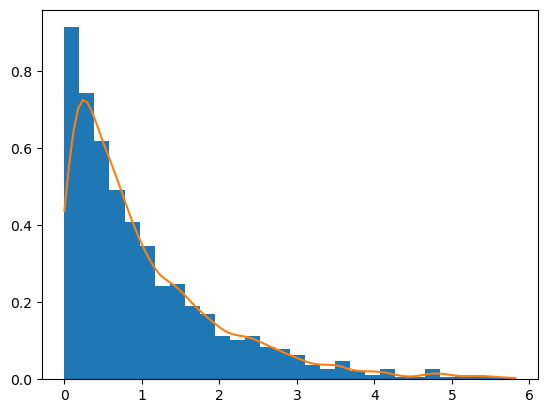

In [152]:
r = np.linspace(min(X), max(X), 100)
p_hat = [kde(X, x, 0.16004844283669575, "gauss") for x in r]
plt.hist(X, bins=30, density=True)
plt.plot(r, p_hat)

### Mean Integrated Squared Error

In [6]:
def mise(X, R, h: float, k: str, pdf):
    p_true = pdf(R)
    p_hat = np.zeros_like(R)
    for i, x in enumerate(R):
        p_hat[i] = kde(X, x, h, k)
        
    return np.sum((p_true - p_hat) ** 2)

def minimize_mise(X, k, pdf, search_space):
    R = np.linspace(min(X), max(X), len(X))
    M = []
    h_mise = 0
    min_mise = 9999
    for h in tqdm(search_space):
        err = mise(X, R, h, "gauss", pdf)
        M.append(err)
        if err < min_mise:
            min_mise = err
            h_mise = h
    return h_mise, min_mise, M

In [154]:
H = np.linspace(0.001, 1, 100)
h_mise, min_mise, M = minimize_mise(
    X, "gauss", lambda x: stats.expon.pdf(x), search_space=H
)
print(f"h_argmin(MISE): {min_mise, h_mise}")

100%|██████████| 100/100 [00:03<00:00, 31.09it/s]

h_argmin(MISE): (1.9269928451086862, 0.05145454545454546)


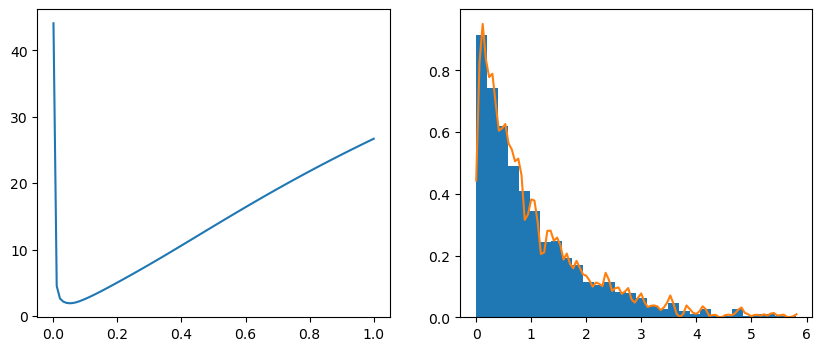

In [155]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(H, M)

plt.subplot(1, 2, 2)
r = np.linspace(min(X), max(X), 100)
p_hat = [kde(X, x, 0.041363636363636366, "gauss") for x in r]
plt.hist(X, bins=30, density=True)
plt.plot(r, p_hat)

### CV Density Estimators

In [7]:
def kde_cv(X: np.array, x: float, h: float, k: str, j: int):
    n = len(X)
    f = 1 / ((n - 1) * h)
    p = 0
    for i in range(n):
        if i == j: continue
        p += kernel((x - X[i]) / h, k)
    return f * p


def kde_cv_mod(X: np.array, x: float, h: float, k: str, j: int):
    n = len(X)
    f = 1 / ((n - 1) * h)
    # p = 0
    # for i in range(n):
    #     if i == j: continue
    #     p += kernel((x - X[i]) / h, k)
        
    p = -kernel((x - X[j]) / h, k)
    p = p + np.sum(kernel((x - X) / h, k))
    return f * p

$$
CV(h) = \int \hat{p}_n^2 - \frac{2}{n} * \sum_{i=1}^n \hat{p}_{n,-i}(X_i)
$$

In [13]:
def int_g_hat(X: np.array, h: float, k: str):
    n = len(X)
    g = 0
    space = np.linspace(-10, 10, n)
    for i, x in enumerate(X):
    # for i, x in enumerate(space):
        g += kde_cv_mod(X, x, h, k, i)
    return 2*g / len(X)

In [19]:
def int_p_hat(X: np.array, h: float, k: str):
    n = len(X)
    p = 0
    space = np.linspace(min(X), max(X), 10*len(X))
    # for i, x in enumerate(X):
    for i, x in enumerate(space):
        p += kde(X, x, h, k) ** 2
    return p / len(X)

In [20]:
def ubcv(X: np.array, k: str, min_h = 0.001, max_h = 1, max_iter = 10):
    h_list = np.linspace(min_h, max_h, max_iter)
    cv_list = []
    for h in tqdm(h_list):
        cv = int_p_hat(X, h, k) - int_g_hat(X, h, k)
        cv_list.append(cv)
    return h_list, cv_list

In [21]:
def mise(y_kde, y_pdf):
    return np.mean((y_pdf - y_kde) ** 2)

def mise_argmin(X: np.array, k: str, pdf_func, min_h = 0.001, max_h = 1, max_iter = 10):
    space = np.linspace(min(X), max(X), 1000)
    h_list = np.linspace(min_h, max_h, max_iter)
    ms_list = []
    for h in tqdm(h_list):
        y_kde = np.zeros_like(space)
        y_pdf = np.zeros_like(space)
        for i, x in enumerate(space):
            y_kde[i] = kde(X, x, h, k)
            y_pdf[i] = pdf_func(x)
        ms = mise(y_pdf, y_kde)
        ms_list.append(ms)
    return h_list, ms_list

### CV Exponential

In [22]:
X = np.random.exponential(size=10000)

In [23]:
h_list, cv_list = ubcv(X, "gauss", max_h = 0.1)

100%|██████████| 10/10 [03:00<00:00, 18.03s/it]


In [24]:
h_cv = h_list[np.argmin(cv_list)]

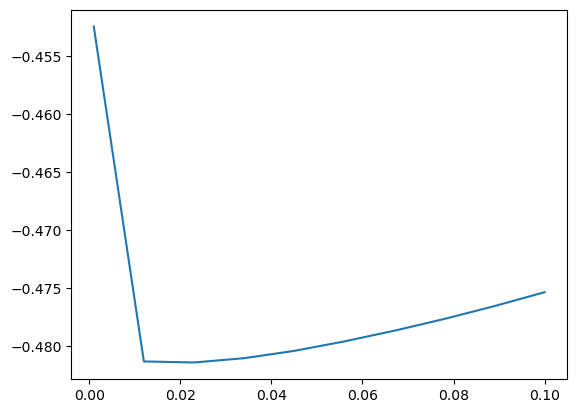

In [25]:
plt.plot(h_list, cv_list)

In [26]:
h_list, ms_list = mise_argmin(
    X, "gauss",
    lambda x: stats.norm.pdf(x),
    max_iter=100
)

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


In [27]:
h_mise = h_list[np.argmin(cv_list)]

In [28]:
h_r = h_rot(X)

In [29]:
print("MISE - h", h_mise)
print("CV - h", h_cv)
print("Rule of thumb - h", h_r)

MISE - h 0.021181818181818184
CV - h 0.023000000000000003
Rule of thumb - h 0.11692249807395302


In [177]:
def mise(y_kde, y_pdf):
    return np.sum((y_pdf - y_kde) ** 2)

In [264]:
space = np.linspace(0, 5, 1000)
y_cv = np.zeros_like(space)
y_rot = np.zeros_like(space)
y_pdf = np.zeros_like(space)
for i, x in enumerate(space):
    y_pdf[i] = stats.expon.pdf(x)
    y_cv[i] = kde(X, x, h_cv, "gauss")
    y_rot[i] = kde(X, x, h_r, "gauss")

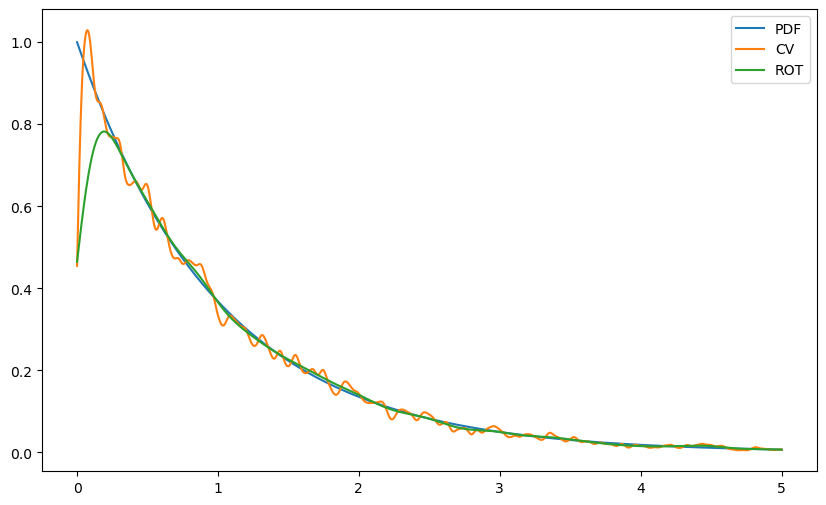

In [265]:
plt.figure(figsize=(10, 6))
# plt.hist(X, density=True, bins=30, label="Dist")
plt.plot(space, y_pdf, label="PDF")
plt.plot(space, y_cv, label="CV")
plt.plot(space, y_rot, label="ROT")
plt.legend()

In [266]:
print("MISE of CV", mise(y_cv, y_pdf))
print("MISE of ROT", mise(y_rot, y_pdf))

MISE of CV 1.096168501885537
MISE of ROT 3.0651915973073782


### CV Normal Distribution

In [268]:
X = np.random.normal(size=10000)

In [283]:
h_list, cv_list = ubcv(X, "gauss", min_h = 0.001, max_h = 0.07)

100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


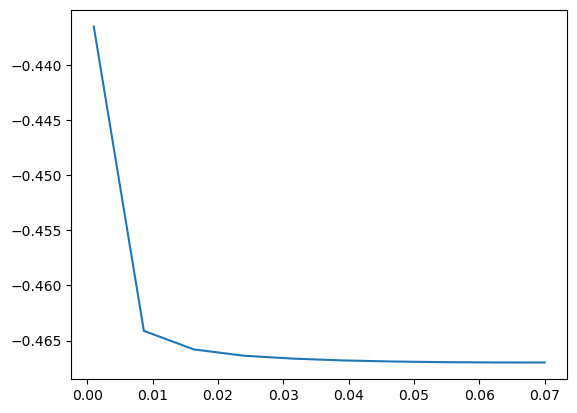

In [284]:
plt.plot(h_list, cv_list)

In [285]:
h_cv = h_list[np.argmin(cv_list)]
h_r = h_rot(X)

In [286]:
space = np.linspace(-3, 3, 1000)
y_cv = np.zeros_like(space)
y_rot = np.zeros_like(space)
y_pdf = np.zeros_like(space)
for i, x in enumerate(space):
    y_pdf[i] = stats.norm.pdf(x)
    y_cv[i] = kde(X, x, h_cv, "gauss")
    y_rot[i] = kde(X, x, h_r, "gauss")

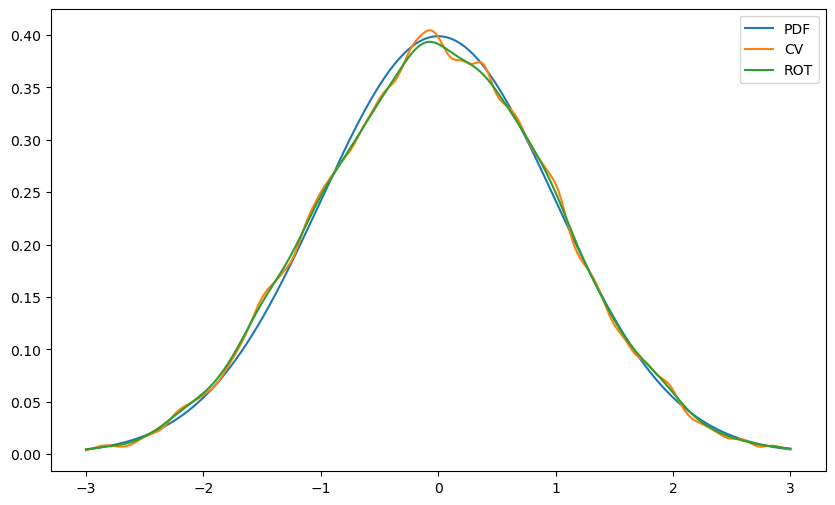

In [287]:
plt.figure(figsize=(10, 6))
# plt.hist(X, density=True, bins=30, label="Dist")
plt.plot(space, y_pdf, label="PDF")
plt.plot(space, y_cv, label="CV")
plt.plot(space, y_rot, label="ROT")
plt.legend()

In [289]:
print("MISE of CV", mise(y_cv, y_pdf))
print("MISE of ROT", mise(y_rot, y_pdf))

MISE of CV 0.05727752330861135
MISE of ROT 0.04738800437597685
